In [21]:
# Risk-Based Premium Modeling Pipeline

import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import shap
import numpy as np

In [22]:
# Load data
df = pd.read_csv("../../data/MachineLearningRating_v3.csv", low_memory=False)
df["TransactionMonth"] = pd.to_datetime(
    df["TransactionMonth"], errors='coerce', dayfirst=True)
df["TransactionYear"] = df["TransactionMonth"].dt.year
df = df.dropna(subset=["TransactionYear", "RegistrationYear",
               "TotalClaims", "TotalPremium", "Province", "Gender"])
df["VehicleAge"] = df["TransactionYear"] - df["RegistrationYear"]
df["HasClaim"] = (df["TotalClaims"] > 0).astype(int)
df_claims = df[df["HasClaim"] == 1].copy()

In [23]:
# Features
features = ["VehicleAge", "TotalPremium", "Province", "Gender"]

In [24]:
# Load preprocessor and models
preprocessor = joblib.load("../../models/preprocessor.pkl")
clf = joblib.load("../../models/probability_model.pkl")
reg = joblib.load("../../models/severity_model.pkl")

In [25]:
# Preprocess data
X_prob = preprocessor.transform(df[features])
y_prob_true = df["HasClaim"]
X_sev = preprocessor.transform(df_claims[features])
y_sev_true = df_claims["TotalClaims"]

In [26]:
# Predictions
p_claim = clf.predict_proba(X_prob)[:, 1]
claim_preds = reg.predict(X_sev)

In [27]:
# Metrics
print("--- Claim Probability Model ---")
print("Accuracy:", accuracy_score(y_prob_true, clf.predict(X_prob)))
print("ROC AUC:", roc_auc_score(y_prob_true, p_claim))

print("\n--- Claim Severity Model ---")
print("RMSE:", np.sqrt(mean_squared_error(y_sev_true, claim_preds)))
print("R²:", r2_score(y_sev_true, claim_preds))

--- Claim Probability Model ---
Accuracy: 0.9971884647301229
ROC AUC: 0.7538380576345264

--- Claim Severity Model ---
RMSE: 17254.81619087086
R²: 0.8015215909100945


In [28]:
# Premium = Prob * Severity + Expenses
risk_based_premium = (p_claim * reg.predict(X_prob)) + 500

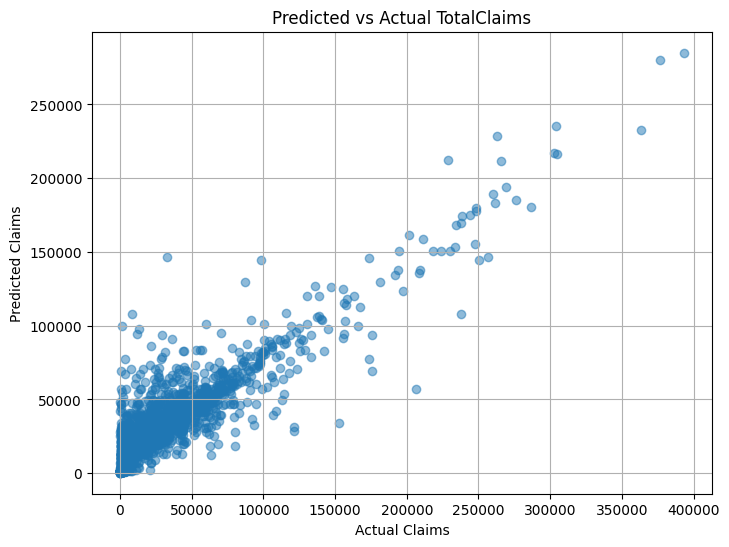

In [29]:
# Plot predicted vs actual (Severity)
plt.figure(figsize=(8, 6))
plt.scatter(y_sev_true, claim_preds, alpha=0.5)
plt.title("Predicted vs Actual TotalClaims")
plt.xlabel("Actual Claims")
plt.ylabel("Predicted Claims")
plt.grid(True)
plt.savefig("../../outputs/task-4/predicted_vs_actual_claims.png")
plt.show()

 99%|===================| 2739/2774 [00:49<00:00]        

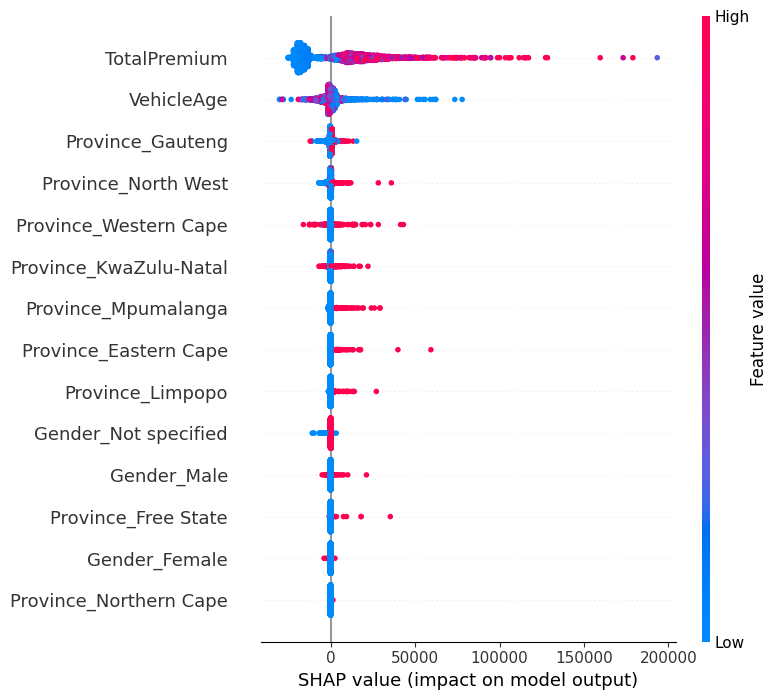

In [30]:
# SHAP summary with proper feature names
num_cols = ["VehicleAge", "TotalPremium"]
cat_cols = ["Province", "Gender"]
ohe = preprocessor.named_transformers_["cat"]
feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

explainer = shap.Explainer(reg, X_sev)
shap_values = explainer(X_sev, check_additivity=False)
shap.summary_plot(shap_values, features=X_sev,
                  feature_names=feature_names, show=False)
plt.savefig("../../outputs/task-4/shap_severity_summary.png")